# Mask Detection using YOLOv8 for face detection

In [18]:
#imports
import torch
import torch.nn as nn
from torchvision import transforms, models
from ultralytics import YOLO

import os
import random
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

#set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [19]:

#load YOLOv8 face detector
face_detector = YOLO('YOLOModel/yolov8m_200e.pt')

# build CNN model using saved weights
def build_model(pretrained=True, num_classes=3):
    #base pretrained model 
    base = models.efficientnet_b0(weights='IMAGENET1K_V1' if pretrained else None)
    #getting feature size before final FC layer
    features = base.classifier[1].in_features
    #take only  feature extractor
    base = nn.Sequential(base.features, nn.AdaptiveAvgPool2d(1))

    model = nn.Sequential(
        base,
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    return model

#instantiate and load CNN
cnn_model = build_model()
cnn_model.load_state_dict(torch.load('Models/CNN_EfficientNet.pth', map_location=device))
cnn_model.to(device)
cnn_model.eval()


Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation): Sigm

In [20]:
#preprocessing functions

#image preprocessing transform for cnn input
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

#applying clahe enhancement
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return enhanced_img

#applying blur enhancement
def apply_gaussian_blur(img, kernel_size=(5,5)):
    return cv2.GaussianBlur(img, kernel_size, 0)

#applying sharpening enhancement
def apply_sharpening(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(img, -1, kernel)
    return sharpened

#pad and resize images as 128x128
def pad_resize(img, size=128):
    h, w, _ = img.shape
    scale = size / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = cv2.resize(img, (new_w, new_h))

    #calculate padding
    top = (size - new_h) // 2
    bottom = size - new_h - top
    left = (size - new_w) // 2
    right = size - new_w - left

    #pad resized image to make it square
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])
    return padded

#extracting ground truth from my personal dataset
def extract_gt_from_filename(filename):
    try:
        return int(filename.split('-')[-1].split('.')[0])
    except:
        return -1


In [21]:
#load random images and preproces 
def load_and_preprocess_images(image_dir, face_detector, transform, num_images=4):

    #list all img files
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    #randomly select a few imgs
    selected_paths = random.sample(image_paths, min(num_images, len(image_paths)))

    #stores preprocessed face crops
    processed_faces = []
    #orignal images used for visualisation
    original_images = [] 
    #bounding boxes
    boxes = []
    #paths of valid imgs with faces
    valid_paths = []

    for path in selected_paths:
        #load img using opencv
        img = cv2.imread(path)
        #convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #saving a copy for visualisation
        original_images.append(img_rgb.copy())

        #detect face with YOLOv8
        results = face_detector.predict(img_rgb, verbose=False)

        #if atleast one face deteced
        if len(results[0].boxes) > 0:
            #get confidence scores
            confs = results[0].boxes.conf.cpu().numpy()
            best_idx = np.argmax(confs) #pick highest confidence box

            h, w, _ = img_rgb.shape
            box = results[0].boxes.xyxy[best_idx].cpu().numpy().astype(int)
            
            # clip bounding box to stay inside the image, mainly for extremely zoomed in imgs
            x1 = max(0, min(box[0], w-1))
            y1 = max(0, min(box[1], h-1))
            x2 = max(0, min(box[2], w-1))
            y2 = max(0, min(box[3], h-1))
            box = [x1, y1, x2, y2]

            
            #crop face from img
            cropped = img_rgb[box[1]:box[3], box[0]:box[2]]
            if cropped.size == 0:
                continue #skip if crop failed

            #apply all of our enhancements to img
            enhanced = apply_clahe(cropped)
            blurred = apply_gaussian_blur(enhanced)
            sharpened = apply_sharpening(blurred)
            padded = pad_resize(sharpened, size=128)

            #convert to PIL and aplly normalizations transforms
            cropped_pil = Image.fromarray(padded)
            #add to batch
            processed_faces.append(transform(cropped_pil))
            #save bounding box
            boxes.append(box)
            #save path
            valid_paths.append(path)
        else:
            print(f"No face detected in: {path}")

    return processed_faces, original_images, boxes, valid_paths

#plot prediction with bounding box
def plot_predictions(images, boxes, preds, paths):
    class_names = ['No Mask', 'Mask', 'Improper Mask']
    plt.figure(figsize=(14, 10))

    for i in range(len(images)):
        img = images[i].copy() # copy img to draw on
        box = boxes[i] #bounding box coords
        pred_label = preds[i] #predicted labels
        #extract ground truth labels from img
        gt_label = extract_gt_from_filename(os.path.basename(paths[i]))

        #check if pred is correct
        correct = pred_label == gt_label
        #green if correct else red
        color = (0, 255, 0) if correct else (255, 0, 0)
        label_text = f"Pred: {class_names[pred_label]} | GT: {class_names[gt_label]}" if gt_label != -1 else f"Pred: {class_names[pred_label]}"

        #draw bounding box on img
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)

        #draw label txt 
        text_y = box[1] - 30 if box[1] - 30 > 20 else box[1] + 50
        cv2.putText(img, label_text, (box[0], text_y),
                     cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 4, cv2.LINE_AA)

        #show img
        plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(paths[i]))

    plt.tight_layout()
    plt.show()

#loads images, runs CNN, plots results
def MaskDetection(path):
    faces, images, boxes, paths = load_and_preprocess_images(path, face_detector, transform)

    if not faces:
        print("No faces detected in selected images.")
        return

    #batch of face tensors
    batch = torch.stack(faces).to(device)
    with torch.no_grad():
        #foward pass through CNN
        outputs = cnn_model(batch)
        #take argmax predictions
        preds = outputs.argmax(1).cpu().numpy()
    
    plot_predictions(images, boxes, preds, paths)


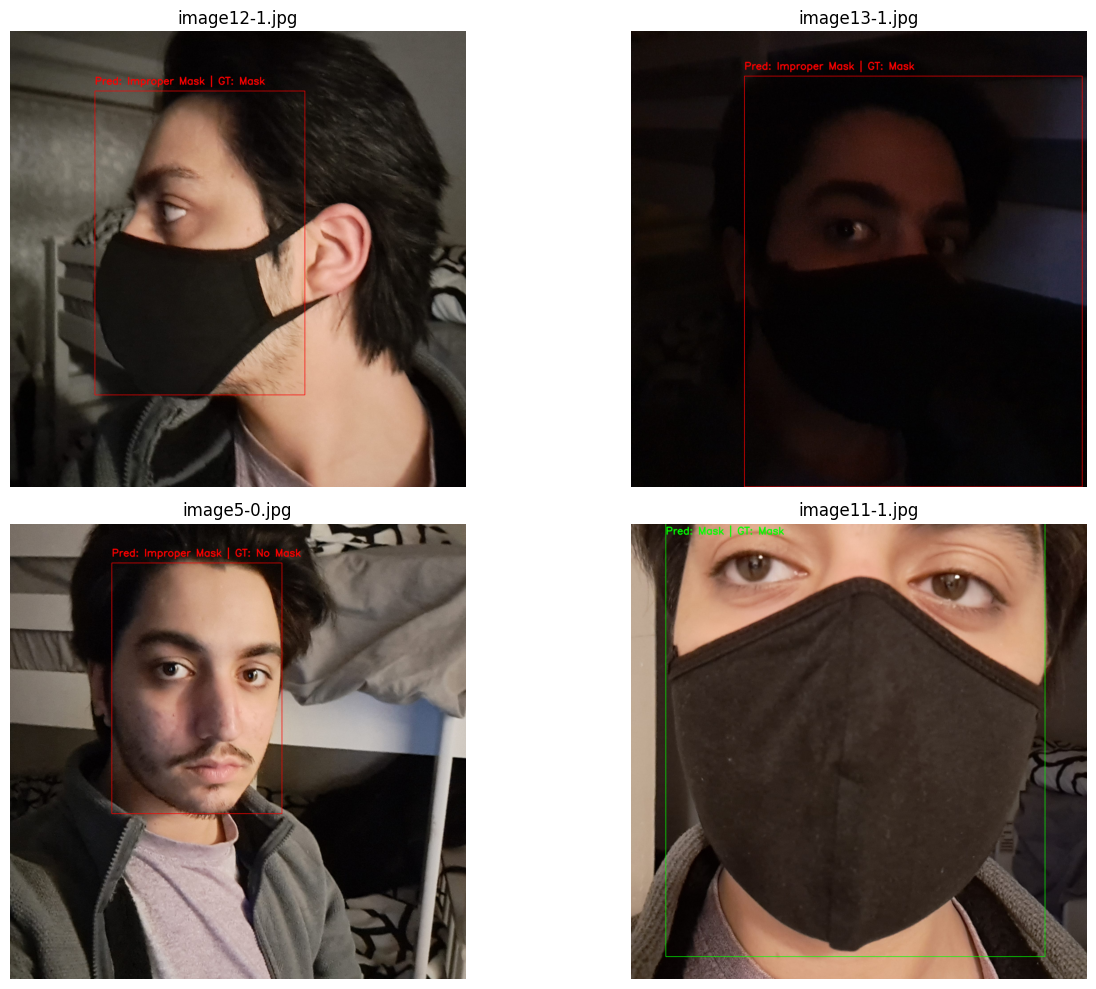

In [43]:
#calling mask func
MaskDetection("PersonalDataset")
